# GRN evaluation with CellOracle
**Authorship:** Adam Klie (last updated: 08/15/2023)<br>
***
**Description:** This notebook 

# Set-up

In [3]:
# Global import
import os
import sys
import yaml
import datetime
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import celloracle as co

# Local import
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

0.14.0


In [26]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [8]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results"

# Inputs
in_analysis = "grn_model_construction"
in_date = "10Aug23"
in_dir = os.path.join(results_dir, dataset_name, in_date, in_analysis)
print(in_dir)

# Outputs
out_analysis = "grn_model_evaluation"
out_date = "10Aug23"
out_dir = os.path.join(results_dir, dataset_name, out_date, out_analysis)
make_dirs(out_dir)

/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results/igvf_sc-islet_10X-Multiome/10Aug23/grn_model_construction


'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results/igvf_sc-islet_10X-Multiome/10Aug23/grn_model_evaluation'

In [13]:
# Make and log a yaml file with the parameters
data_params = {
    "dataset_name": dataset_name,
    "results_dir": results_dir,
    "in_analysis": in_analysis,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_analysis": out_analysis,
    "out_date": out_date,
    "out_dir": out_dir,
}
version_params = {
    "Python": sys.version[:5],
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "scanpy": sc.__version__,
    "seaborn": sns.__version__,
    "celloracle": co.__version__,
}
params = {"data": data_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "grn_model_construction_params.yaml")):
    with open(os.path.join(out_dir, "grn_model_construction_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [19]:
# Load the links
links = co.load_hdf5(os.path.join(in_dir, "grn.celloracle.links"))
links

In [20]:
links.palette

,palette
SC.EC,#1F77B4
SC.alpha,#FF7F0E
SC.beta,#2CA02C
SC.delta,#D62728
pre.SC.alpha,#9467BD
progenitor,#8C564B


In [18]:
# Load the oracle
oracle = co.load_hdf5(os.path.join(in_dir, "grn.celloracle.oracle"))
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 30000
    n_genes: 2999
    cluster_name: predicted.cell.type
    dimensional_reduction_name: X_umap_wnn
    n_target_genes_in_TFdict: 19395 genes
    n_regulatory_in_TFdict: 1095 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 151 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1903 genes
    k_for_knn_imputation: 750
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

# Analyze the links for each cell type

In [22]:
links.links_dict.keys()

dict_keys(['SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta', 'pre.SC.alpha', 'progenitor'])

In [23]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [24]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 30000
    n_genes: 2999
    cluster_name: predicted.cell.type
    dimensional_reduction_name: X_umap_wnn
    n_target_genes_in_TFdict: 19395 genes
    n_regulatory_in_TFdict: 1095 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 151 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1903 genes
    k_for_knn_imputation: 750
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

SC.EC


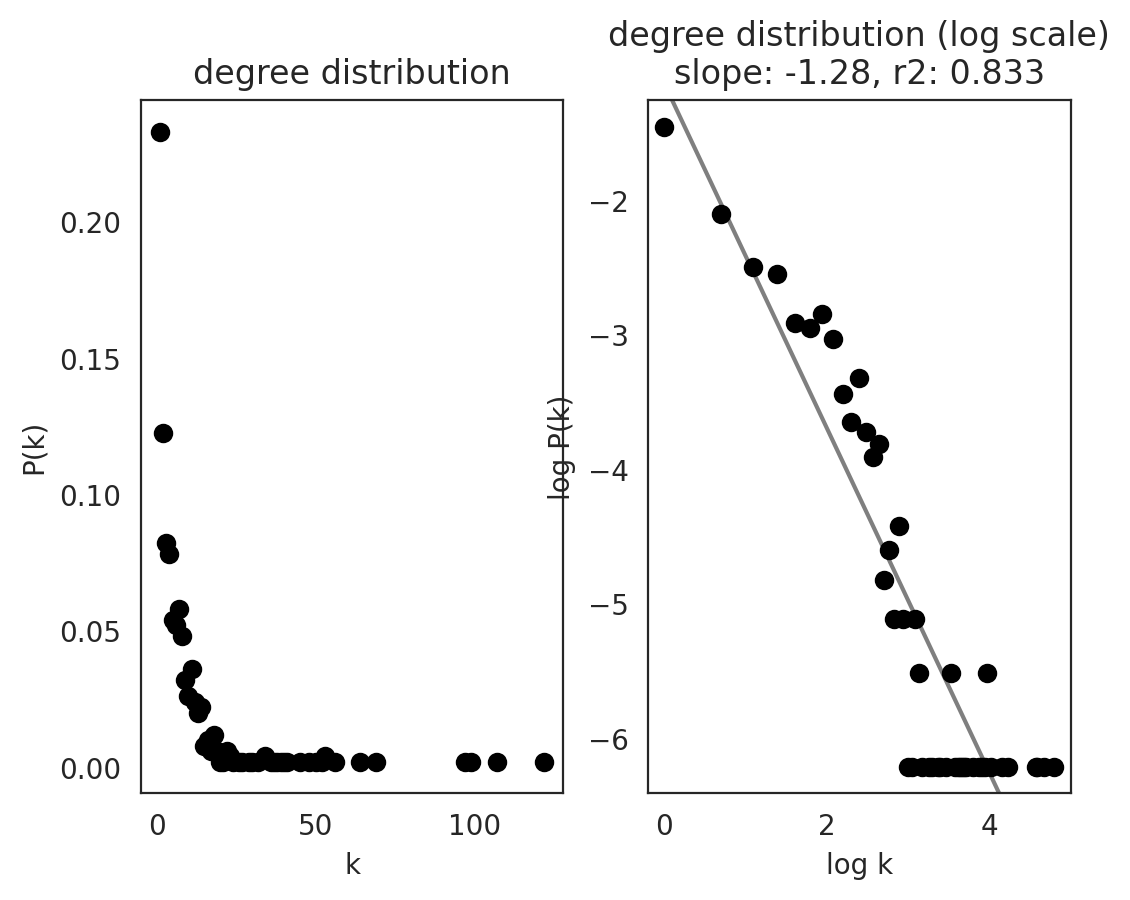

SC.alpha


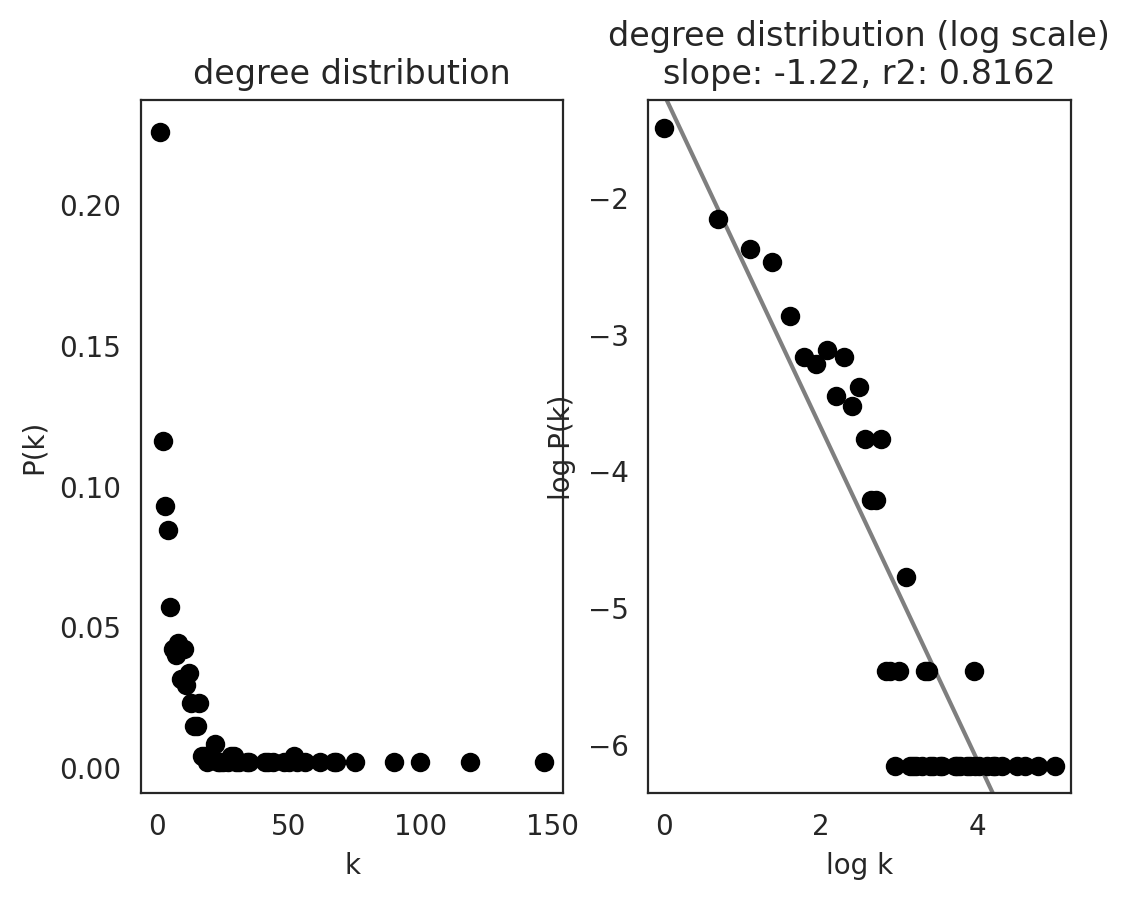

SC.beta


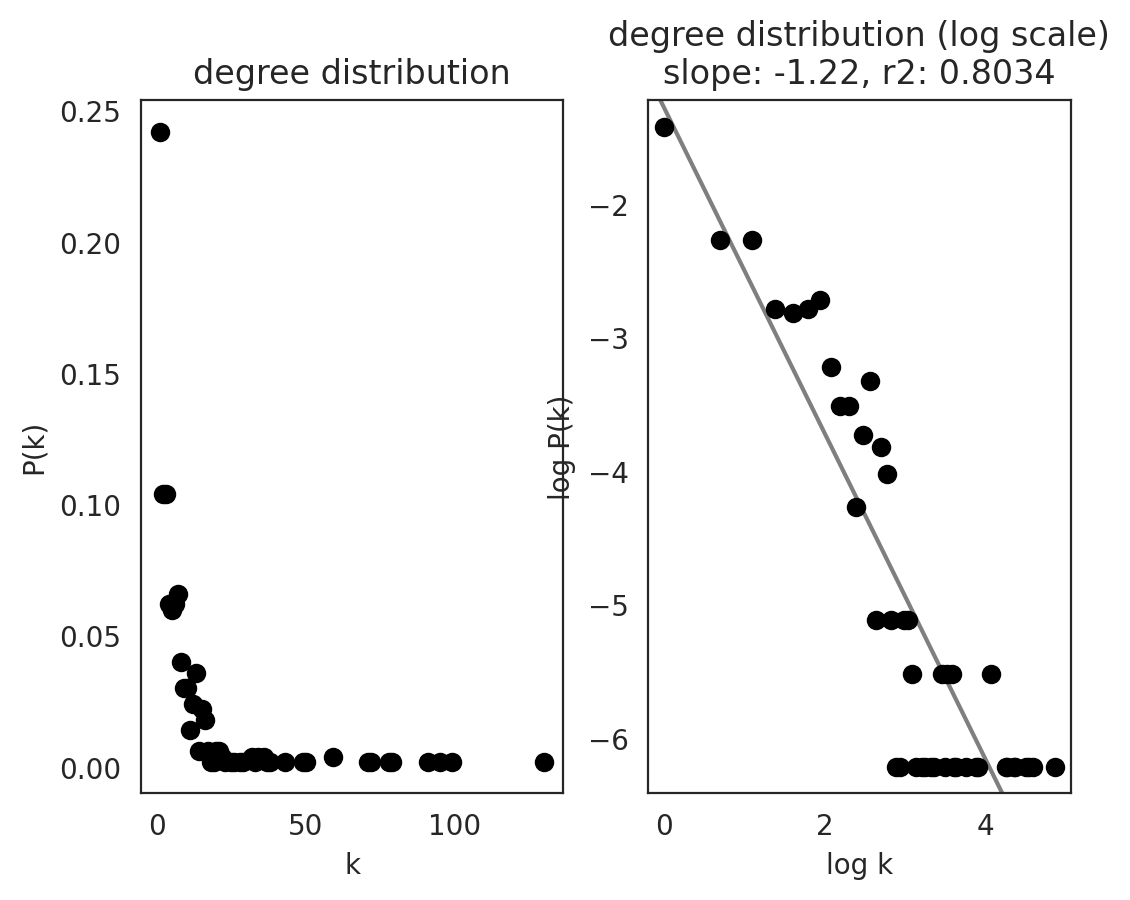

SC.delta


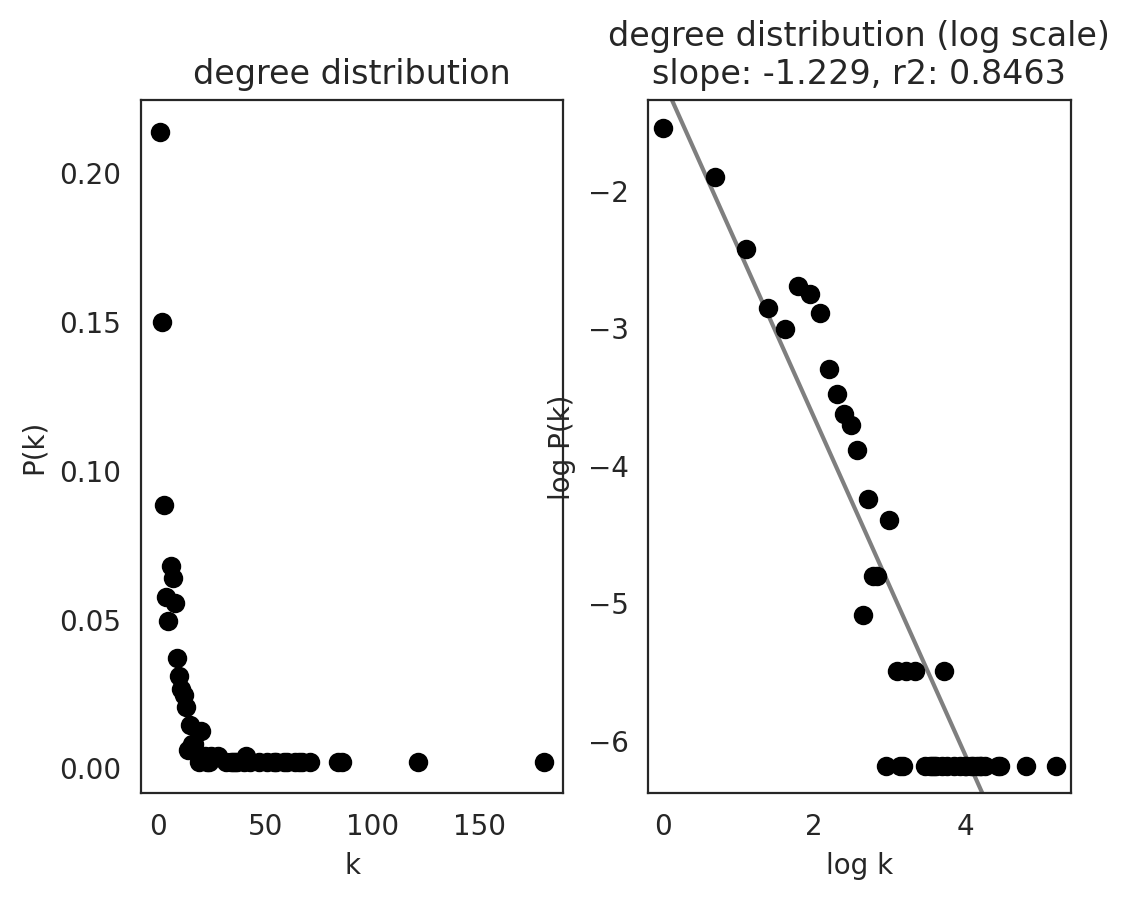

pre.SC.alpha


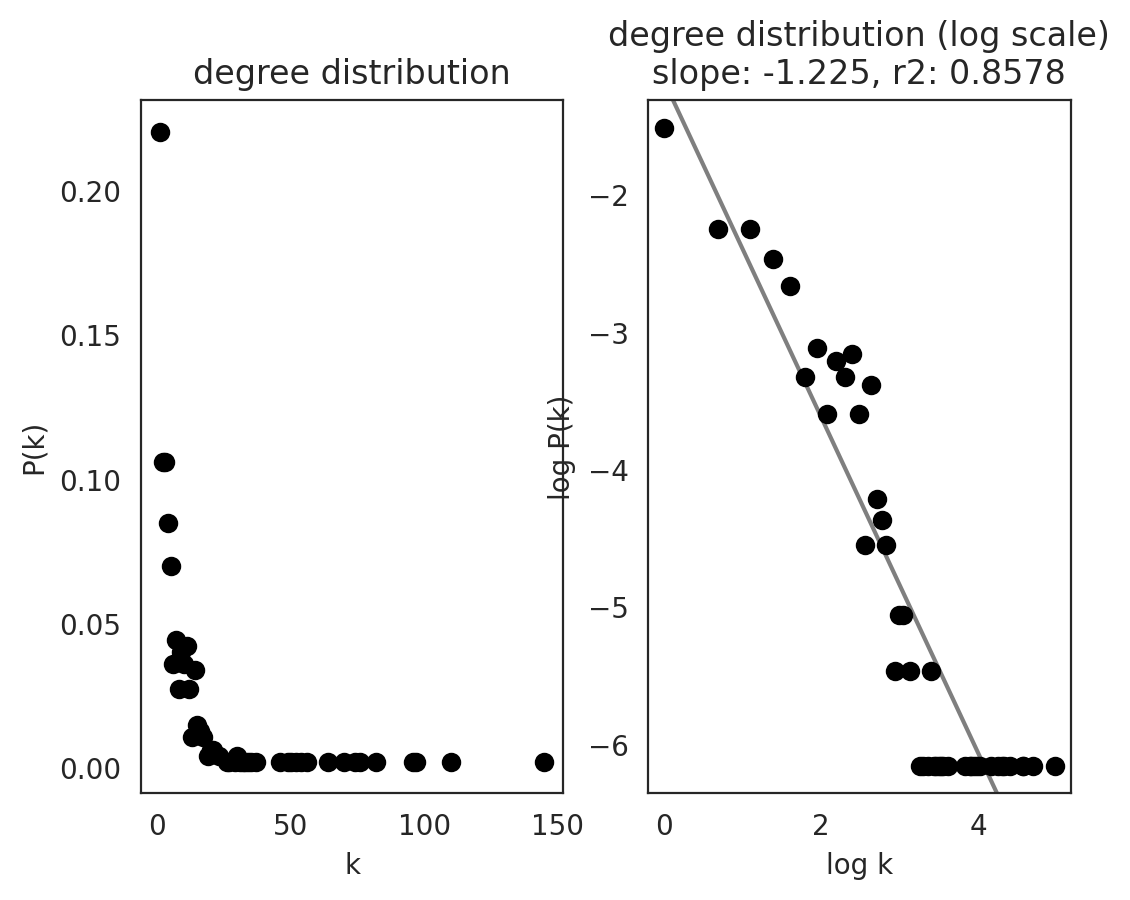

progenitor


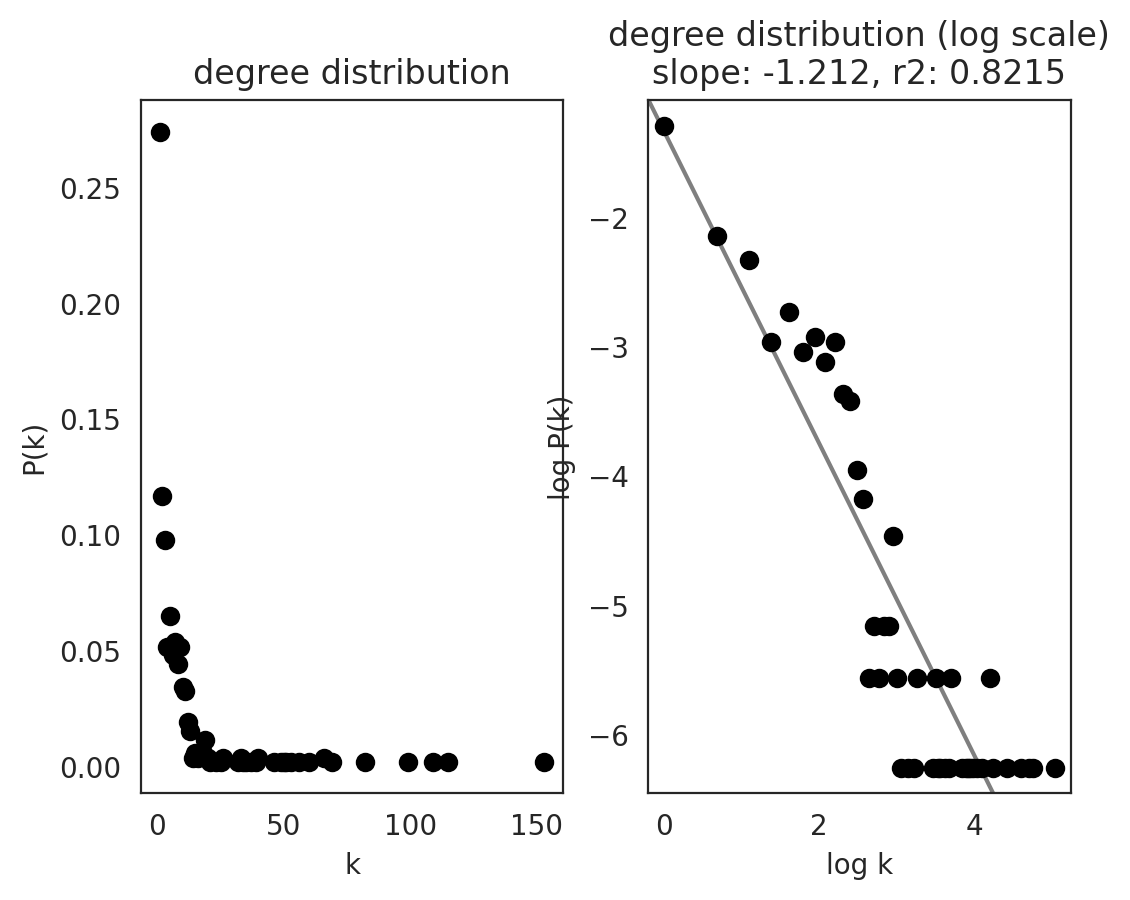

In [27]:
links.plot_degree_distributions(plot_model=True)

In [28]:
# Calculate network scores.
links.get_network_score()

In [29]:
# Check it and save
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
NFIA,23,0.046278,0,0.000000,23,0.046278,0.0,0.420167,SC.EC
DACH2,8,0.016097,8,0.016097,0,0.000000,0.0,0.328988,SC.EC
ZIC1,107,0.215292,0,0.000000,107,0.215292,0.0,0.973742,SC.EC
AFF3,7,0.014085,7,0.014085,0,0.000000,0.0,0.339864,SC.EC
NFIB,22,0.044266,0,0.000000,22,0.044266,0.0,0.221868,SC.EC


In [30]:
links.merged_score.to_csv(os.path.join(out_dir, "network_scores.csv"))

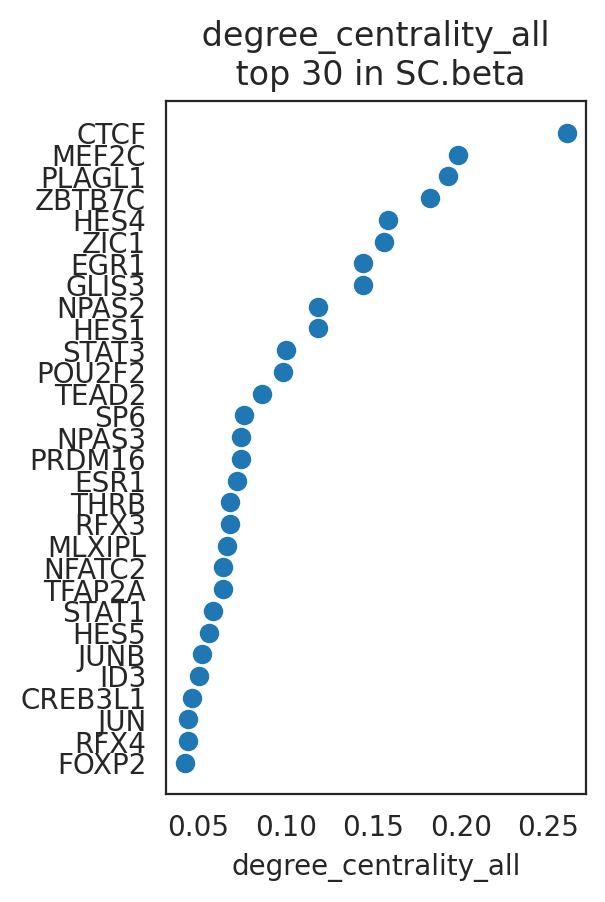

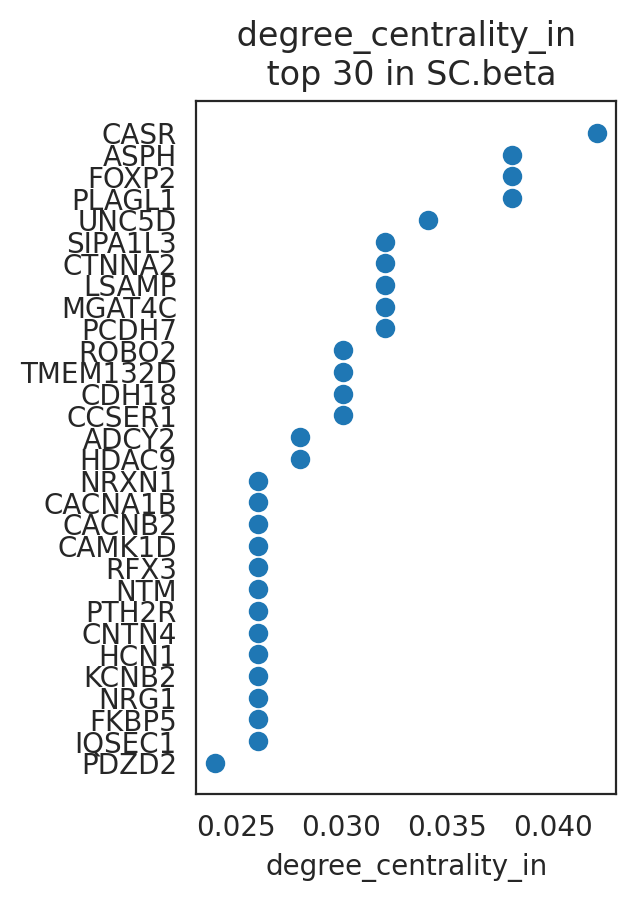

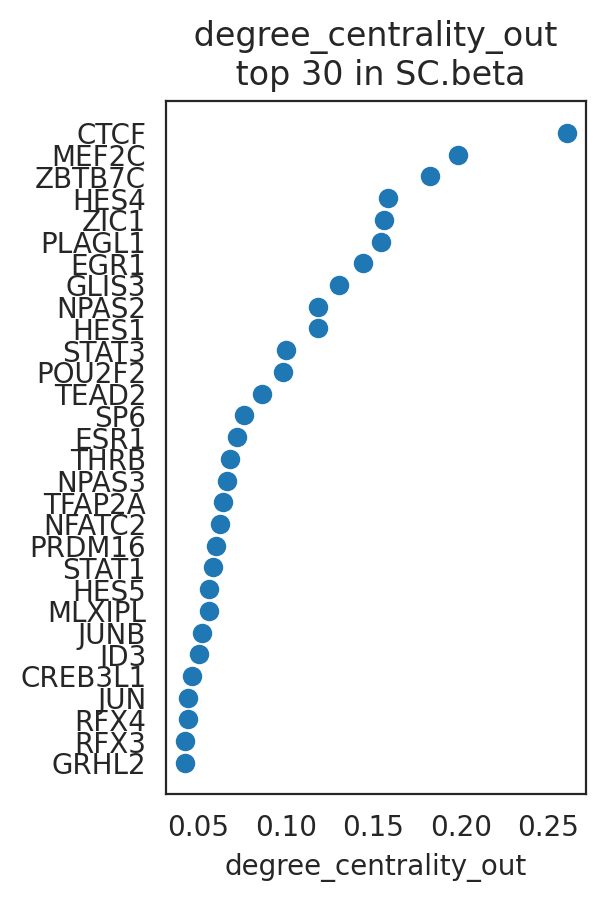

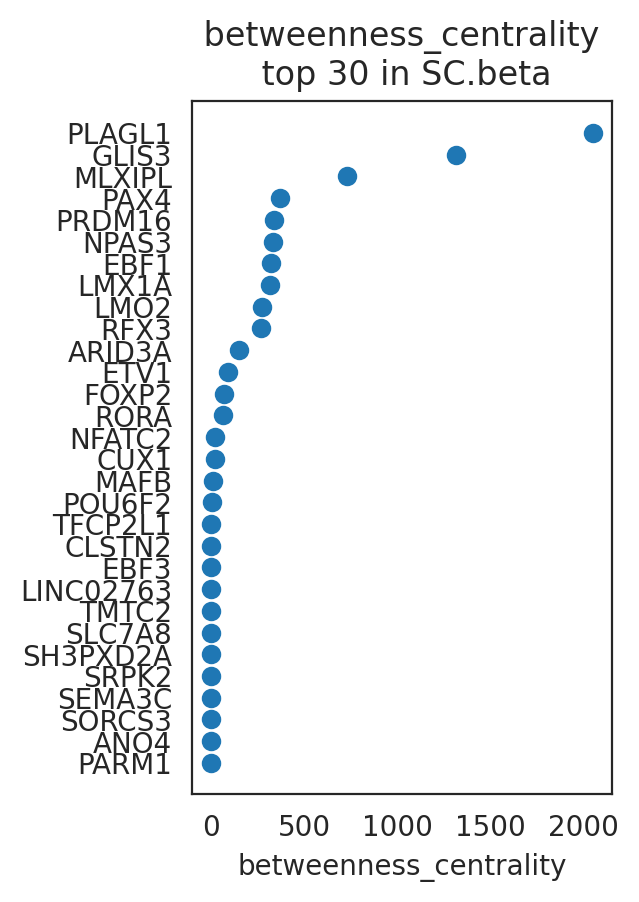

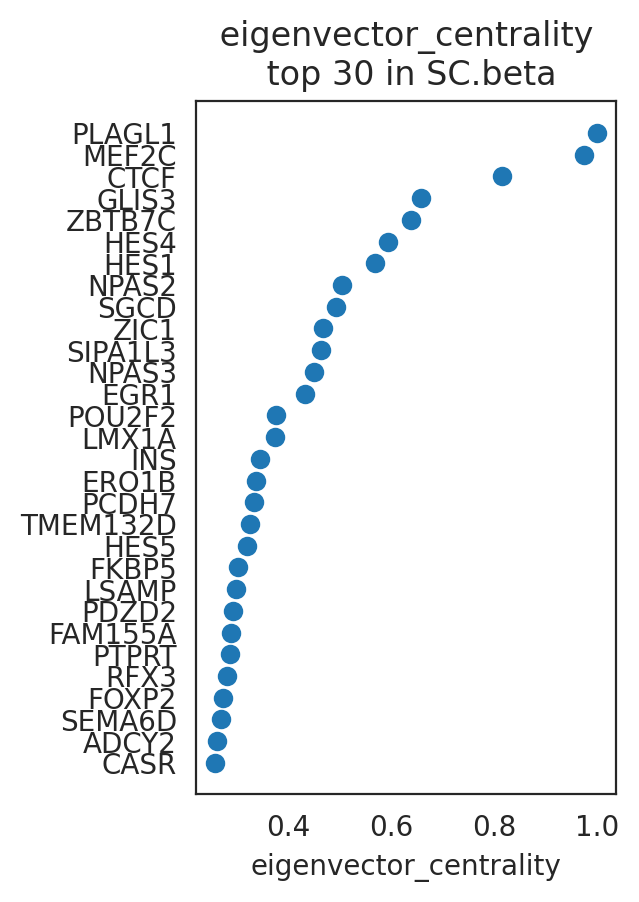

In [39]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="SC.beta", n_gene=30)

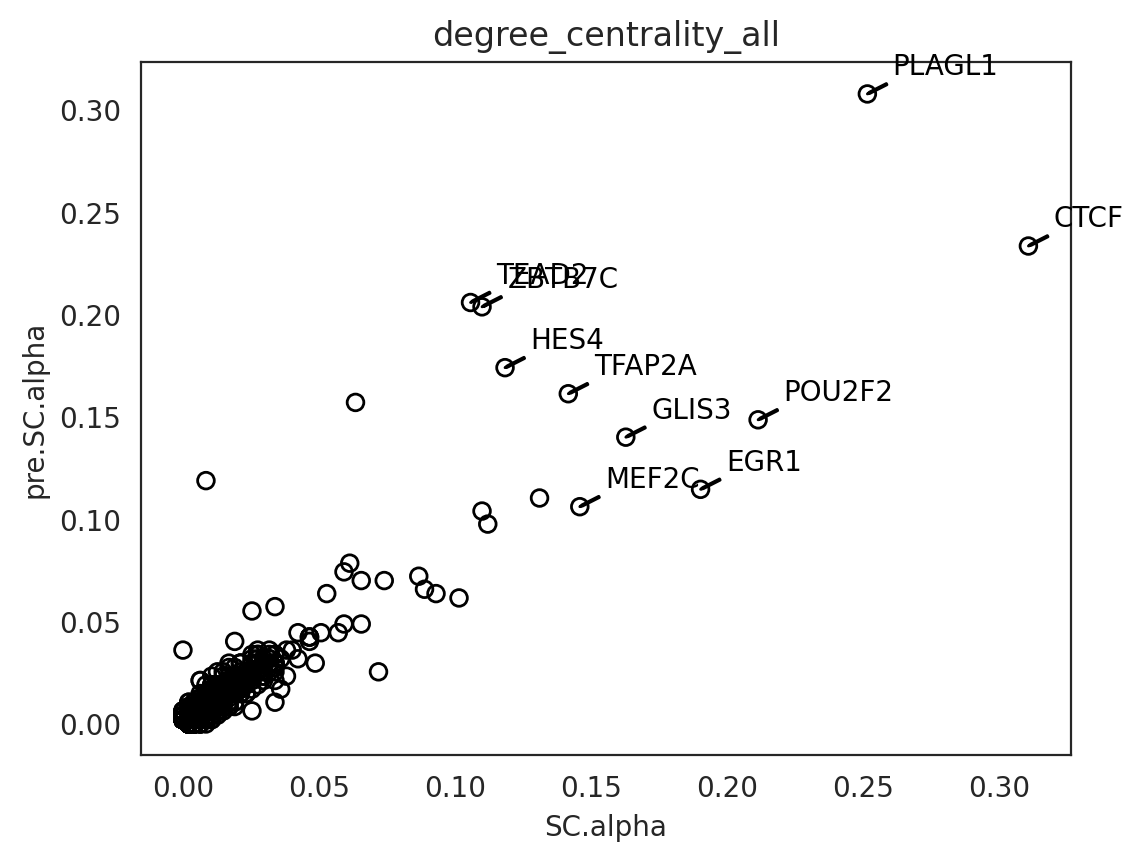

In [32]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(
    value="degree_centrality_all",
    cluster1="SC.alpha", 
    cluster2="pre.SC.alpha",
)

CTCF


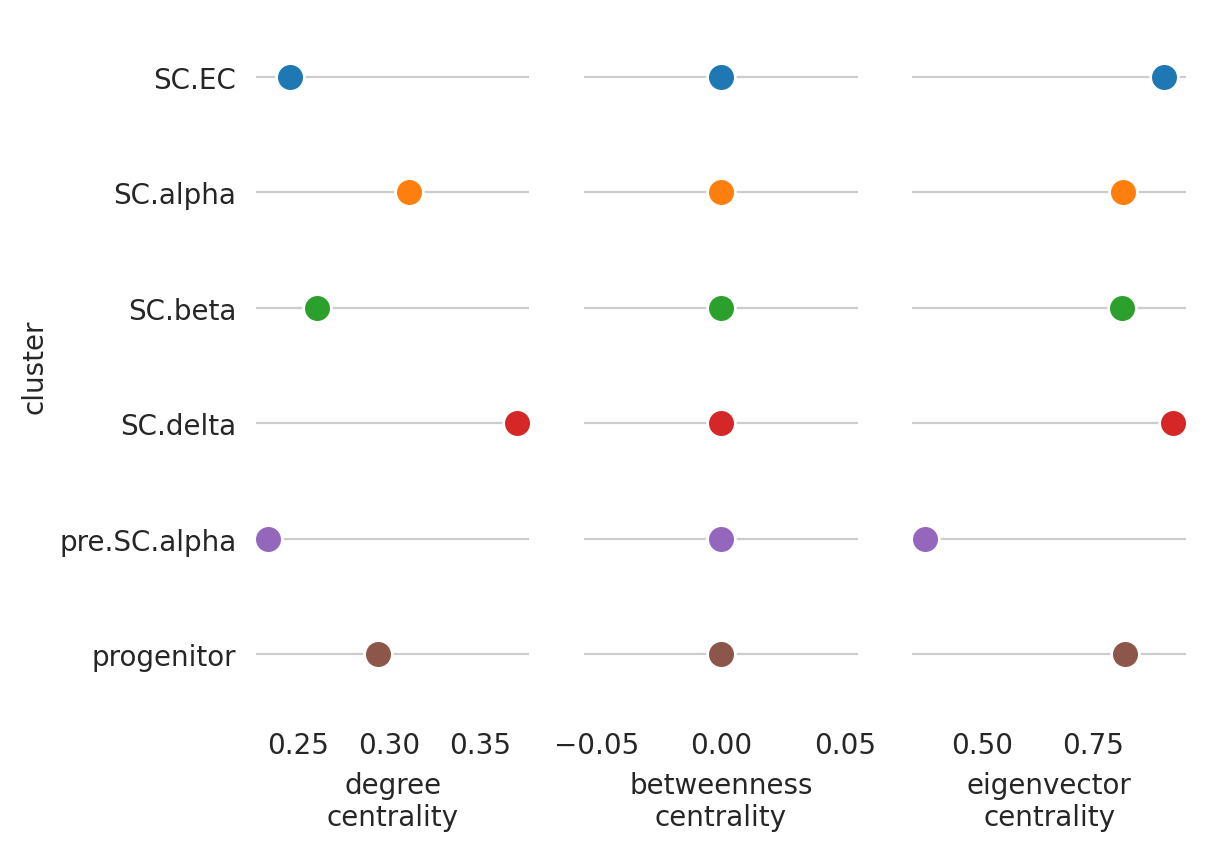

In [34]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="CTCF")

In [38]:
cluster_name = "SC.beta"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

,source,target,coef_mean,coef_abs,p,-logp
43653,MEF2C,SGCD,0.731644,0.731644,1.156995e-10,9.936669
7245,GLI3,CCSER1,-0.719851,0.719851,1.729318e-14,13.762125
35599,PKNOX2,PCDH7,-0.673868,0.673868,4.079614e-07,6.389381
48274,GRHL2,TENM2,0.566009,0.566009,1.153759e-13,12.937885
43647,CTCF,SGCD,-0.560784,0.560784,5.865561e-20,19.231690


In [44]:
filtered_links_df[filtered_links_df["source"] == "MEF2C"].sort_values("coef_abs", ascending=False).iloc[:10]

,source,target,coef_mean,coef_abs,p,-logp
43653,MEF2C,SGCD,0.731644,0.731644,1.156995e-10,9.936669
11850,MEF2C,DACH1,0.535097,0.535097,2.405061e-13,12.618874
23245,MEF2C,INS,-0.450797,0.450797,8.853090e-11,10.052905
12297,MEF2C,DGKB,0.344921,0.344921,6.511350e-07,6.186329
30068,MEF2C,MGAT4C,-0.327660,0.327660,4.534352e-12,11.343485
37211,MEF2C,PLAGL1,-0.319845,0.319845,4.680401e-10,9.329717
37343,MEF2C,PLCL1,0.299021,0.299021,3.212113e-08,7.493209
31920,MEF2C,NAV3,0.297374,0.297374,2.847689e-11,10.545507
30579,MEF2C,MIR7-3HG,-0.284698,0.284698,9.224378e-14,13.035063
22405,MEF2C,IAPP,-0.280709,0.280709,7.933028e-13,12.100561


degree_centrality_all


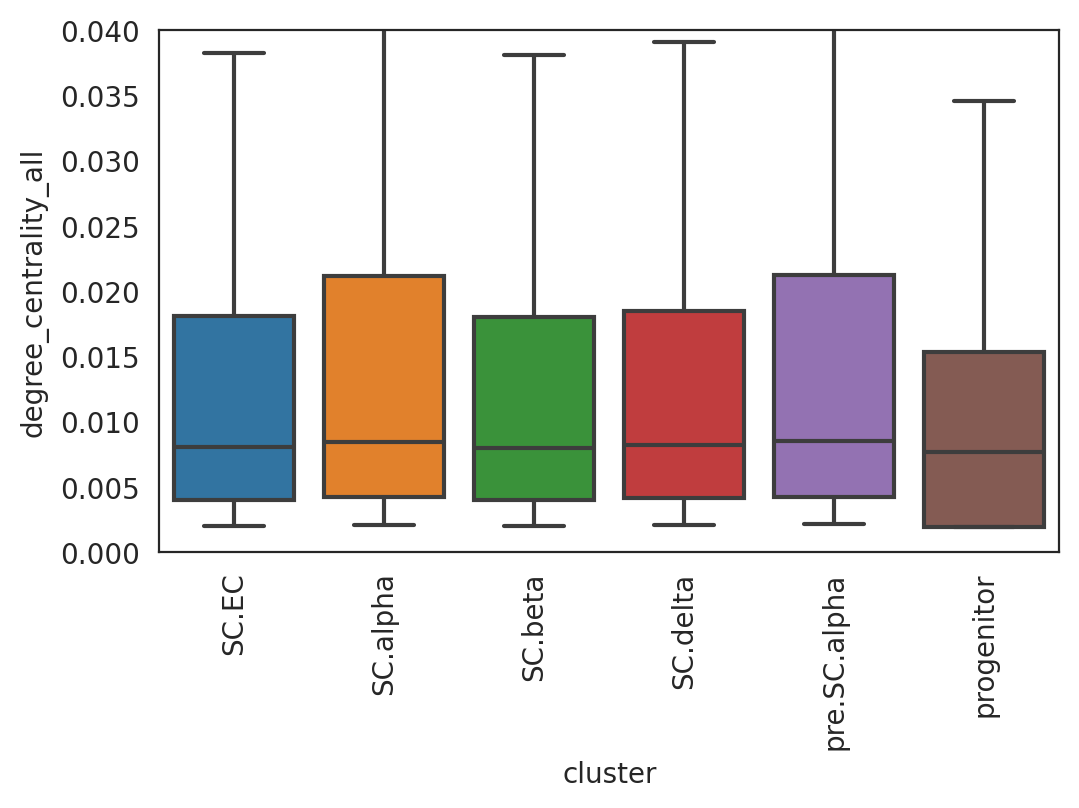

In [36]:
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"],
                               method="boxplot",
                              )

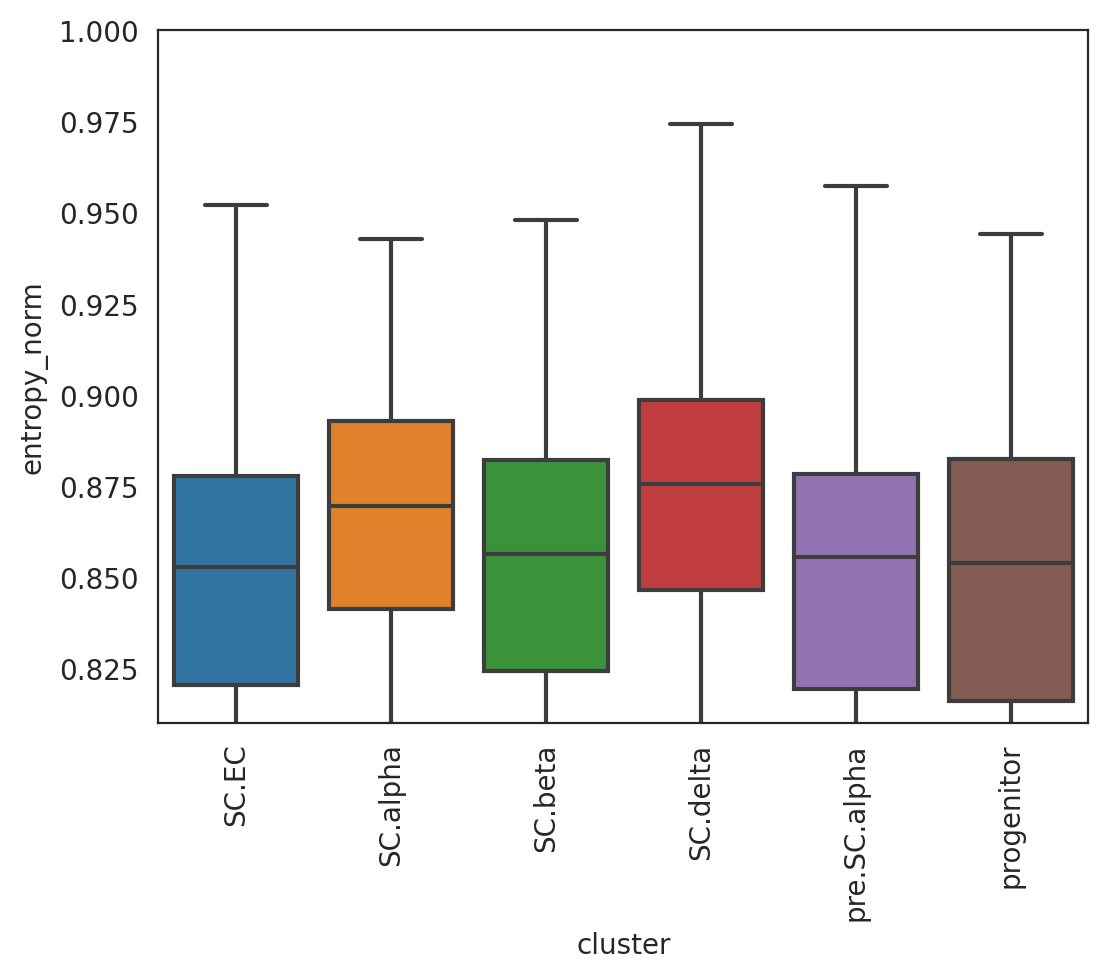

In [37]:
links.plot_network_entropy_distributions()